# <center> Main code for Training and Predicting </center>

<B> Comment: </B> you could easily use this notebook instead of the A3_Moalla_Fatma_main.py file as all results and tests were performed on it (via Google Collab).

# Step up 

In [1]:
# Import pytorch
!pip install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip install torchvision 
import torch
print(torch.__version__)
print(torch.cuda.is_available())

     |████████████████████████████████| 512.6MB 1.2MB/s 
ERROR: torchvision 0.4.2 has requirement torch==1.3.1, but you'll have torch 0.4.1 which is incompatible.
ERROR: fastai 1.0.59 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1
     |████████████████████████████████| 734.6MB 23kB/s 
  Found existing installation: torch 0.4.1
    Uninstalling torch-0.4.1:
      Successfully uninstalled torch-0.4.1
     |████████████████████████████████| 5.6MB 2.8MB/s 
ERROR: torchvision 0.4.2 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.15.0 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninsta

1.3.1
True


In [43]:
# import pillow
!pip install Pillow==4.0.0

# I- Data processing and visualization

### a. Apply transformations

In [0]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy



# Define Train_images transformations
data_transforms_train = transforms.Compose([
    transforms.RandomResizedCrop(256),
    transforms.CenterCrop(224),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

# Define validation_images transformations: only cropping,resizing and normalizing
data_transforms_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])




In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [93]:
cd '/content/gdrive/My Drive/'

/content/gdrive/My Drive


In [0]:
# Tranform training and validation sets:

dataset = 'bird_dataset'
batch_size = 5

train_datasets = datasets.ImageFolder(dataset + '/train_images',
                         transform=data_transforms_train)

train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True, num_workers=1)

val_datasets =  datasets.ImageFolder(dataset + '/val_images',transform=data_transforms_val)
val_loader = torch.utils.data.DataLoader(val_datasets,batch_size=batch_size, shuffle=False, num_workers=1)


dataloaders = {'train':train_loader, 'val':val_loader}
dataset_sizes = {'train':len(train_datasets), 'val':len(val_datasets)}

class_names_train = train_datasets.classes

### b. Visualize transformed images

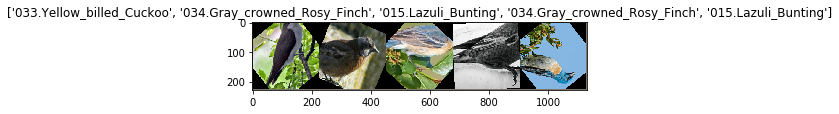

In [95]:
# Visulize some transformed training images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names_train[x] for x in classes])

# II- Train_model

### a. Training set-up

In [0]:
# Function to train the model:

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
# to Try testing
torch.manual_seed(123)

def model_choice(name='resnet152'):
    if name =='vgg19_bn':
        model_ft = models.vgg19_bn(pretrained='imagenet')
        num_ftrs = model_ft.classifier[6].in_features
        features = list(model_ft.classifier.children())[:-1]
        model_ft.classifier = nn.Sequential(*features)
    else:
        if name == "resnext":
            model_ft = models.resnext50_32x4d(pretrained=True)
            num_ftrs = model_ft.fc.in_features
            model_ft.fc = nn.Linear(num_ftrs, 20)

        if name=='resnet152':
            model_ft = models.resnet152(pretrained=True)
            num_ftrs = model_ft.fc.in_features
            model_ft.fc = nn.Linear(num_ftrs, 20)

        elif name=='resnet101':
            model_ft = models.resnet101(pretrained=True)
            num_ftrs = model_ft.fc.in_features
            model_ft.fc = nn.Linear(num_ftrs, 20)
        elif name=='inception':
            model_ft = models.inception_v3(pretrained=True)
            num_ftrs = model_ft.AuxLogits.fc.in_features
            model_ft.AuxLogits.fc = nn.Linear(num_ftrs,20)
            num_ftrs = model_ft.fc.in_features
            model_ft.fc = nn.Linear(num_ftrs,20)
            input_size = 299
        else:
            model_ft = models.resnet18(pretrained=True)
            num_ftrs = model_ft.fc.in_features
            model_ft.fc = nn.Linear(num_ftrs, 20)
    return model_ft.to(device)



In [79]:
# Check if the GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### b. Train the chosen model

In [80]:
# Define a base model
name = 'resnet101'

model_ft = model_choice(name=name)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [81]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 2.6342 Acc: 0.1885
val Loss: 1.0764 Acc: 0.5922

Epoch 1/49
----------
train Loss: 1.9561 Acc: 0.4094
val Loss: 1.0036 Acc: 0.7573

Epoch 2/49
----------
train Loss: 1.7512 Acc: 0.4797
val Loss: 0.6967 Acc: 0.7573

Epoch 3/49
----------
train Loss: 1.6853 Acc: 0.4908
val Loss: 0.9752 Acc: 0.6893

Epoch 4/49
----------
train Loss: 1.7048 Acc: 0.4908
val Loss: 0.8303 Acc: 0.7767

Epoch 5/49
----------
train Loss: 1.6623 Acc: 0.5111
val Loss: 1.2284 Acc: 0.7184

Epoch 6/49
----------
train Loss: 1.4011 Acc: 0.5702
val Loss: 0.6573 Acc: 0.8155

Epoch 7/49
----------
train Loss: 1.2567 Acc: 0.6183
val Loss: 0.8141 Acc: 0.8058

Epoch 8/49
----------
train Loss: 1.1538 Acc: 0.6516
val Loss: 0.6783 Acc: 0.8155

Epoch 9/49
----------
train Loss: 1.1973 Acc: 0.6460
val Loss: 0.6427 Acc: 0.8544

Epoch 10/49
----------
train Loss: 1.1432 Acc: 0.6608
val Loss: 0.5941 Acc: 0.8350

Epoch 11/49
----------
train Loss: 1.1052 Acc: 0.6728
val Loss: 0.6359 Acc: 0.8350

Epoch 12/49
----------
t

### III- Predict

### a. Prediction set-up

In [0]:
# Directory of mistery dataset:
test_dir ='/content/gdrive/My Drive/'+ dataset+ '/test_images/mistery_category'

# Directory of mistery cropped dataset processed in the file 'Cropping_images.ipynb':
test_dir2='/content/gdrive/My Drive/test_images_cropped'

In [0]:
# Function to Load test images
from tqdm import tqdm
import os
import PIL.Image as Image

def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

### b. Predict on non_cropped

In [84]:
cd /content/gdrive/My Drive/bird_dataset

/content/gdrive/My Drive/bird_dataset


In [85]:
# Generate the kaggle.csv file for non-cropped testing set
outfile = 'kaggle_resnet_gray_non_crop.csv'
use_cuda = torch.cuda.is_available()

output_file = open('/content/gdrive/My Drive/kaggle_resnet_gray_non_crop.csv', 'w')

output_file.write("Id,Category\n")
for f in os.listdir(test_dir):
    if 'jpg' in f:
        data = data_transforms_val(pil_loader(test_dir + '/' + f))
        data = data.view(1, data.size(0), data.size(1), data.size(2))
        if use_cuda:
            data = data.cuda()
        output = model_ft(data)
        pred = output.data.max(1, keepdim=True)[1]
        output_file.write("%s,%d\n" % (f[:-4], pred))

output_file.close()

print("Succesfully wrote " + outfile + ', you can upload this file to the kaggle competition website')

Succesfully wrote kaggle_resnet_gray_non_crop.csv, you can upload this file to the kaggle competition website


### c. Predict on cropped

In [86]:
cd '/content/gdrive/My Drive/test_images_cropped'

/content/gdrive/My Drive/test_images_cropped


In [90]:
# Generate the kaggle.csv file for cropped testing set
output_file = open('/content/gdrive/My Drive/kaggle_resnet_gray_non_crop.csv', 'w')
outfile ='kaggle_resnet_gray_non_crop.csv'
output_file.write("Id,Category\n")
for f in os.listdir(test_dir2):
    if 'jpg' in f:
        data = data_transforms_val(pil_loader(test_dir2 + '/' + f))
        data = data.view(1, data.size(0), data.size(1), data.size(2))
        if use_cuda:
            data = data.cuda()
        output = model_ft(data)
        pred = output.data.max(1, keepdim=True)[1]
        output_file.write("%s,%d\n" % (f[:-12], pred))

output_file.close()

print("Succesfully wrote " + outfile + ', you can upload this file to the kaggle competition website')

Succesfully wrote kaggle_resnet_gray_non_crop.csv, you can upload this file to the kaggle competition website
